# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
import cv2
import pickle
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

signs_names = pd.read_csv('./signnames.csv')

NameError: name 'pd' is not defined

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
n_train = len(train['features'])
n_test = len(test['features'])
image_shape = '{}x{}'.format(len(train['features'][0]), len(train['features'][0][0]))
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

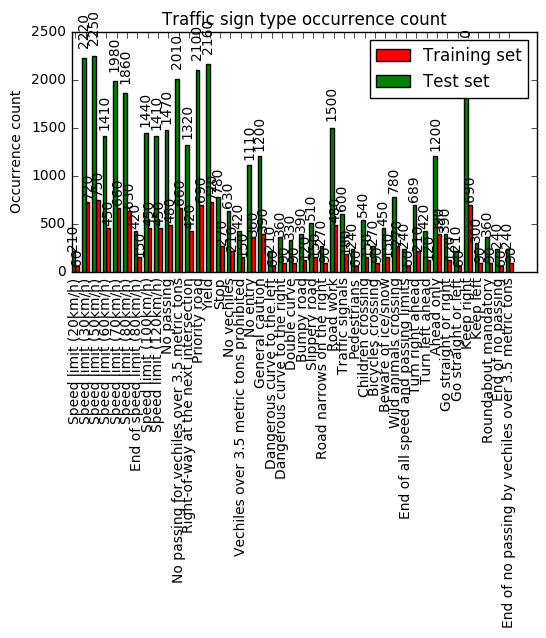

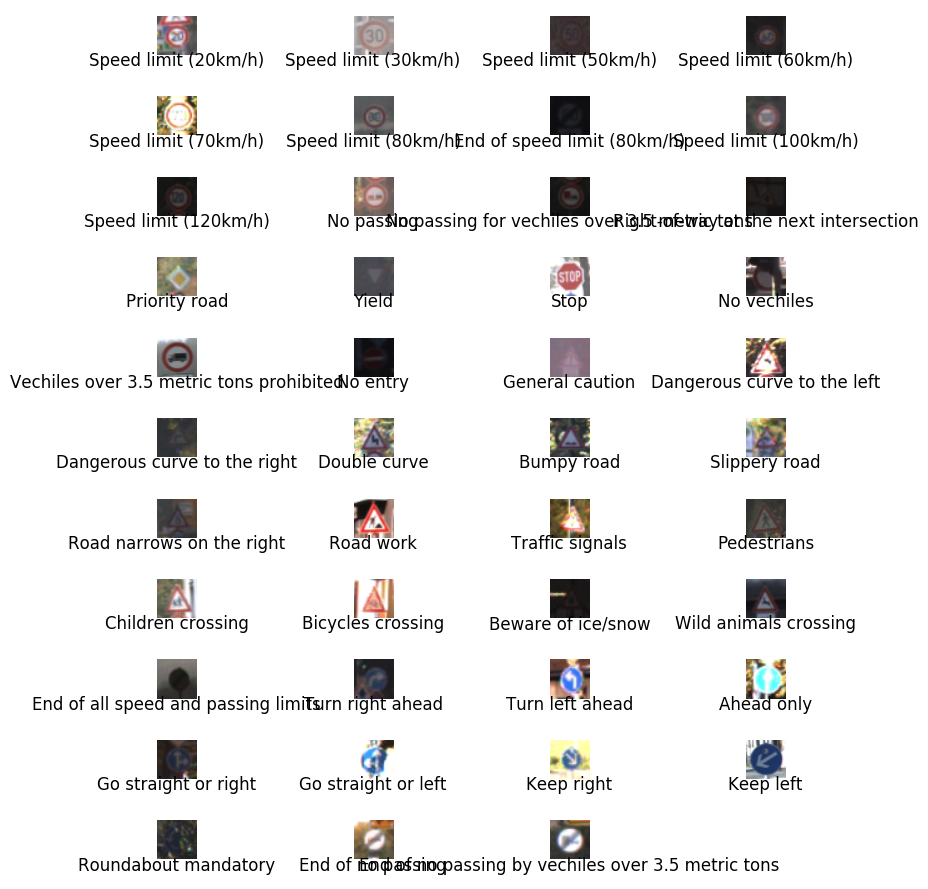

In [3]:
%matplotlib inline

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom', rotation='vertical')

train_counts = np.bincount(y_train)
test_counts = np.bincount(y_test)

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(n_classes) + 0.35, test_counts, 0.35, color='r')
rects2 = ax.bar(np.arange(n_classes), train_counts, 0.35, color='g')

ax.set_ylabel('Occurrence count')
ax.set_title('Traffic sign type occurrence count')
ax.legend((rects1[0], rects2[0]), ('Training set', 'Test set'))
ax.set_xticks(np.arange(n_classes) + 0.35)
ax.set_xticklabels(signs_names['SignName'], rotation='vertical')
autolabel(rects1)
autolabel(rects2)
plt.subplots_adjust(top=0.95, bottom=0.35)


# * Plot gallery of traffic signs examples
def iter_axes(ax):
    for row in ax:
        for col in row:
            yield col
unique_signs = []

for sign_type in range(n_classes):
    sign_index = np.where(y_train == sign_type)[0][0]
    unique_signs.append([sign_type, X_train[sign_index]])

n_cols = 4
n_rows = math.ceil(n_classes/n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 9))
fig.tight_layout()

axes_iterator = iter_axes(axes)
for sign, subplot in zip(unique_signs, axes_iterator):
    subplot.axis('off')
    subplot.set_title(signs_names[signs_names.ClassId == sign[0]].SignName.values[0], y=-0.45)
    subplot.imshow(sign[1])
for remaining_subplot in axes_iterator:
    remaining_subplot.axis('off')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
def add_more_training_examples(X, y):
    numbers_to_equalize = [3000 - i for i in train_counts]

    additional_X = []
    additional_y = []

    for index in range(len(numbers_to_equalize)):
        for sign, label in zip(X, y):
            if numbers_to_equalize[index] > 0 and label == index:
                for angle in [-10, -8, -6, -2, -1, 1, 2, 4, 8, 10]:
                    (h, w) = sign.shape[:2]
                    center = (w / 2, h / 2)
                    M = cv2.getRotationMatrix2D(center, angle, 1.0)
                    rotated = cv2.warpAffine(sign, M, (w, h))
                    additional_X.append(rotated)
                    additional_y.append(label)
                    numbers_to_equalize[index] -= 1
                    if numbers_to_equalize[index] > 0:
                        continue

    return np.concatenate((np.asarray(additional_X), X)), np.concatenate((np.asarray(additional_y), y))

X_train, y_train = add_more_training_examples(X_train, y_train)

########### Binarize labels

encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

########### Split training dataset into training and validation set.

X_train, X_validation, train_labels, validation_labels = train_test_split(X_train, train_labels, test_size=0.25)


########### Preprocess data

def preprocess(dataset):
    preprocessed = []
    dst = np.zeros(shape=(32, 32))
    for traffic_sign in dataset:
        yuv_image = cv2.cvtColor(traffic_sign, cv2.COLOR_BGR2YUV)
        grayscale = yuv_image[:, :, 0]
        grayscale = cv2.normalize(grayscale, dst, 0, 255, cv2.NORM_MINMAX)
        preprocessed.append(np.reshape(grayscale, (32, 32, 1)))
    return preprocessed

X_train = preprocess(X_train)
X_validation = preprocess(X_validation)
X_test = preprocess(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I've based my preprocessing method on the conclusions drawn from the Sermanet's and LeCun's whitepaper. Basically I've converted images to YUV color space, then used only Y channel so they were considered as grayscale images only. Color was omited due to different lighting conditions of the images in a dataset. Then I've performed minmax normalization in order to make data better conditioned for learning.  

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I've split training set loaded from a file into two separate datasets - training and validation one. The size of the validation set was 25% of the overall sample count. Before that I've generated more training examples due to some classes having significantly lower sample counts than the others. It's been done by applying -10 to 10 degree rotation around the center of an image. Some other techniques, like applying random jitter, could also be used.

In [5]:
def LeNet(x):
    a_mean = 0
    a_sigma = 0.1

    # Convolution layer 1. 32x32x1 to 28x28x6.
    conv_1 = tf.nn.conv2d(
        x,
        tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=a_mean, stddev=a_sigma)),
        strides=[1, 1, 1, 1],
        padding='VALID'
    )
    conv_1 = tf.nn.bias_add(conv_1, tf.Variable(tf.zeros(6)))
    conv_1 = tf.nn.relu(conv_1)

    # Pooling layer 28x28x6 to 14x14x6
    pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolution layer 2. 14x14x6 to 10x10x16
    conv_2 = tf.nn.conv2d(
        pool_1,
        tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=a_mean, stddev=a_sigma)),
        strides=[1, 1, 1, 1],
        padding='VALID'
    )
    conv_2 = tf.nn.bias_add(conv_2, tf.Variable(tf.zeros(16)))
    conv_2 = tf.nn.relu(conv_2)

    # Pooling layer 2. 10x10x16 to 5x5x16
    pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten 5x5x16 to 400
    flattened = flatten(pool_2)

    fully_connected_1 = tf.add(
        tf.matmul(flattened, tf.Variable(tf.truncated_normal([400, 120], mean=a_mean, stddev=a_sigma))),
        tf.Variable(tf.zeros(120))
    )
    # fully_connected_1 = tf.nn.dropout(fully_connected_1, 0.7)
    fully_connected_1 = tf.nn.relu(fully_connected_1)

    fully_connected_2 = tf.add(
        tf.matmul(fully_connected_1, tf.Variable(tf.truncated_normal([120, 84], mean=a_mean, stddev=a_sigma))),
        tf.Variable(tf.zeros(84))
    )
    # fully_connected_2 = tf.nn.dropout(fully_connected_2, 0.6)
    fully_connected_2 = tf.nn.relu(fully_connected_2)

    out = tf.add(
        tf.matmul(fully_connected_2, tf.Variable(tf.truncated_normal([84, n_classes], mean=a_mean, stddev=a_sigma))),
        tf.Variable(tf.zeros(n_classes))
    )
    return out


train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None, n_classes))
fc2 = LeNet(x)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I've taken advantage of the LeNet-5 architecture depicted in one of the lessons which looks as follows:

1. convolutional layer with strides of 1 and valid padding, relu has been used as an activation function, input was size of 32x32x1, a layer generated an output sized 28x28x6
2. pooling layer which took an input of 28x28x6 and turned it into 14x14x6 output thanks to kernel size and strides of 2,
3. another convolutional layer with same padding and activation function as previous one, made 14x14x6 input into 10x10x16 output
4. another pooling layer which turned 10x10x16 input into 5x5x16 output,
5. input was flattened so I've obtained a vector of 400 elements,
6. fully connected layer with relu (input of 400 elements -> 120 output),
7. one more fully connected layer with relu (120 -> 84),
8. output layer which returned 43 element vector



In [11]:
logits = tf.nn.softmax_cross_entropy_with_logits(fc2, y)
loss_op = tf.reduce_mean(logits)
opt = tf.train.AdamOptimizer(learning_rate=0.0001)
train_op = opt.minimize(loss_op)

EPOCHS = 100
BATCH_SIZE = 50

correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def eval_data(sess, X_eval, y_eval):
    num_examples = len(X_eval)
    total_acc = 0
    for i in range(0, num_examples, BATCH_SIZE):
        current_batch_X = X_eval[i: i + BATCH_SIZE]
        current_batch_y = y_eval[i: i + BATCH_SIZE]
        batch_acc = sess.run(accuracy_op, feed_dict={x: current_batch_X, y:current_batch_y})
        total_acc += (batch_acc * len(current_batch_X))
    return total_acc/num_examples


sess = tf.Session()
sess.run(tf.initialize_all_variables())
num_examples = len(X_train)
for epoch in range(EPOCHS):
    X_train, train_labels = shuffle(X_train, train_labels)
    for i in range(0, num_examples, BATCH_SIZE):
        batch_x = X_train[i: i + BATCH_SIZE]
        batch_y = train_labels[i: i + BATCH_SIZE]
        loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})

    val_acc = eval_data(sess, X_validation, validation_labels)
    print("EPOCH {} ...".format(epoch + 1))
    print("Validation accuracy = {:.3f}".format(val_acc))
    print()
test_acc = eval_data(sess, X_test, test_labels)
print('Test set accuracy: ', test_acc)

EPOCH 1 ...
Validation accuracy = 0.638

EPOCH 2 ...
Validation accuracy = 0.836

EPOCH 3 ...
Validation accuracy = 0.902

EPOCH 4 ...
Validation accuracy = 0.932

EPOCH 5 ...
Validation accuracy = 0.951

EPOCH 6 ...
Validation accuracy = 0.962

EPOCH 7 ...
Validation accuracy = 0.968

EPOCH 8 ...
Validation accuracy = 0.973

EPOCH 9 ...
Validation accuracy = 0.973

EPOCH 10 ...
Validation accuracy = 0.977

EPOCH 11 ...
Validation accuracy = 0.980

EPOCH 12 ...
Validation accuracy = 0.980

EPOCH 13 ...
Validation accuracy = 0.982

EPOCH 14 ...
Validation accuracy = 0.986

EPOCH 15 ...
Validation accuracy = 0.985

EPOCH 16 ...
Validation accuracy = 0.986

EPOCH 17 ...
Validation accuracy = 0.986

EPOCH 18 ...
Validation accuracy = 0.988

EPOCH 19 ...
Validation accuracy = 0.986

EPOCH 20 ...
Validation accuracy = 0.988

EPOCH 21 ...
Validation accuracy = 0.982

EPOCH 22 ...
Validation accuracy = 0.990

EPOCH 23 ...
Validation accuracy = 0.988

EPOCH 24 ...
Validation accuracy = 0.989

E

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I've initially used GradientDescent optimizer as it was the only optimizer I conceptually understood and I prefer using tools I know how to work with. I've set batch size to 50 and epochs to 100. Learning rate was set to 0.001. It resulted in accuracy of ~98,5% on validation set and ~88.5% on test set. Then I've tried to use some other optimizers to see whether the results are superior. Finally I've settled on AdamOptimizer which yielded best results.

Batch size and number of epochs were chosen experimentally. Using lower values of batch size, made training process much more computationally expensive while having little or no increase in accuracy score. Larger values resulted in lower accuracy score. The range of batch size values I've tried was 1 - 250 with a step of 10. Number of epochs was chosen 100 because the network stopped improving it's accuracy beyond that number. I'd normally try to plot learning curves to choose that number but in this case I've just look at loss function value decrease.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

As I'm new to convolutional neural networks and tensorflow I wanted to fiddle with something I've been acquainted to. That's why I've started with LeNet-5 architecture and gradient descent optimizer. Usually I do grid or randomized search to find the best performing hiperparameter set, but in this case I've just tried changing them manually so I can see how do they affect resulting model accuracy. As I've mentioned I've chosen GD optimizer at first as it is an algorithm I know from other ML toolkits then moved to Adam optimizer. I'm also aware that other architectures, like the ones depicted in LeCun's and Sermanet's whitepaper might work much better than Lenet. Actually, in case of having to do the real thing I'd definetelly start with the solutions depicted in this or similar whitepapers. I've also tried to introduce dropout regularization due to my network overfitting data but as a result it yielded worse results than without regularization. 

The best result in terms of accuracy I've managed to get was ~99,5% on validation set and ~92% on test set.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
import os
import scipy

additional_images = []
additional_image_labels = [40, 39, 17, 2, 9]
binarized_additional_image_labels = encoder.transform(additional_image_labels)

for image in os.listdir('./additional_images'):
    read_image = scipy.misc.imread('./additional_images/' + image)
    additional_images.append(read_image)
    
additional_images = np.asarray(additional_images)
preprocessed_additional_images = preprocess(additional_images)

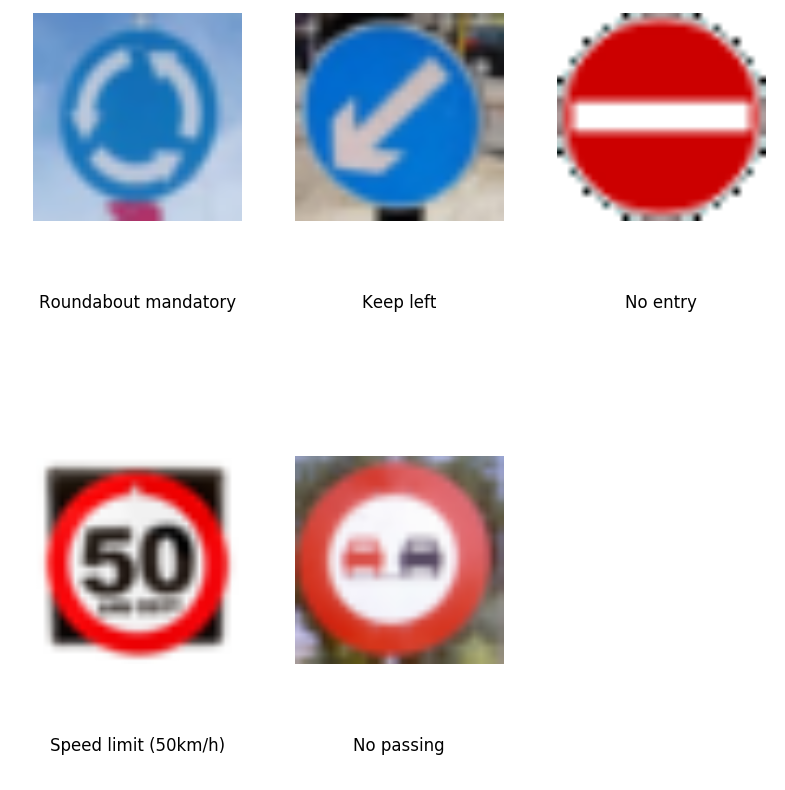

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 9))
fig.tight_layout()

axes_iterator = iter_axes(axes)
i = 0 
for sign, subplot in zip(additional_images, axes_iterator):
    subplot.axis('off')
    subplot.set_title(signs_names[signs_names.ClassId == additional_image_labels[i]].SignName.values[0], y=-0.45)
    subplot.imshow(sign)
    i += 1
for remaining_subplot in axes_iterator:
    remaining_subplot.axis('off')
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In order to further evaluate my network I've used 5 traffic sign images found on the internet. Two of them have artificial background which is never the case in the dataset. Speed limit 50 km/h has additional writing on it "and sexy". It's not a regular traffic sign then. Additionally, area in an image, taken by traffic signs might bring more difficulties in classification. To be specific. Traffic signs that can be found in the german traffic sign dataset occupy significantly lesser space than the ones I've used in this test.

In [14]:
print('My images accuracy: ', sess.run(accuracy_op, feed_dict={x:preprocessed_additional_images, y: binarized_additional_image_labels}))
print('My images correct predictions', sess.run(correct_prediction, feed_dict={x:preprocessed_additional_images, y: binarized_additional_image_labels}))

My images accuracy:  0.6
My images correct predictions [ True False  True False  True]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Although I've achieved ~90% accuracy on test set, I've got only 60% accuracy on new images. One possible reason for that may be my model strongly overfitting images in the dataset. As I've mentioned before, I've used images with much larger area taken by a sign itself than examples in dataset. Therefore my network may fail to match this particullar representation. I also wonder whether perfect lighting conditions in the images I provided, may result in worse network performance which was trained on the images with differing lighting conditions.

In [15]:
print('My images top 3 probabilities', sess.run(tf.nn.top_k(tf.nn.softmax(fc2), k=3), feed_dict={x:preprocessed_additional_images, y: binarized_additional_image_labels}))

My images top 3 probabilities TopKV2(values=array([[  1.00000000e+00,   1.87804757e-17,   1.44197661e-18],
       [  8.90153587e-01,   1.09846406e-01,   8.02902189e-09],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  6.45644546e-01,   3.54345888e-01,   8.20121841e-06],
       [  1.00000000e+00,   3.36653143e-14,   4.52493244e-28]], dtype=float32), indices=array([[40, 12, 11],
       [ 2, 39,  7],
       [17,  0,  1],
       [ 3,  2,  6],
       [ 9, 10, 16]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

3 out of 5 predictions on the signs found on the internet were correct. The other two could be found on the second most probable predictions. In the case of properly classified samples model was practically 100% certain about the chosen class. The probabilities in the cases of improper classification were much lower.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.